<a href="https://colab.research.google.com/github/BenUCL/Reef-acoustics-and-AI/blob/main/Tutorial/3-Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine learning with coral reef soundscape data**

This notebook is a supporting tutorial for the study **Unlocking the soundscape of coral reefs with artificial intelligence** by [Williams et al (2024a)](https://www.biorxiv.org/content/10.1101/2024.02.02.578582v1). If you use any of these methods after reading this then please cite the article.

In this publication we recommend combining pretrained neural networks with unsupervised learning for analysing soundscape ecology.


What this notebook does:
1. Use UMAP to explore data qualitatively.
2. Use UMAP to reduce dimensions of data and then train an unsupervised clustering algorithm to explore data quantitatively.






# **Step 1: Set up**

First, lets mount our Google Drive again.

## Install UMAP
UMAP is not a standard package on Colab so we need to start by installing it. This is typically using the terminal. We can use an '!' before code to run it as a terminal command.

In [1]:
# Install UMAP
import umap

2024-10-02 16:32:27.801671: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-02 16:32:27.950496: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 16:32:28.004488: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 16:32:28.020127: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-02 16:32:28.128102: I tensorflow/core/platform/cpu_feature_guar

In [2]:
#@title Import packages
import os # for handling files and directories
import librosa # for audio processing
import tensorflow as tf # for machine learning
import tensorflow_hub as hub # for machine learning
import numpy as np # for numerical processing
import pandas as pd # for handling dataframes
from tqdm import tqdm # for progress bar
import matplotlib.pyplot as plt # for potting
from sklearn.cluster import KMeans # for clustering

# To get reproducabel results, we set the seed
random_seed = 42

In [3]:
#@title Set all filepaths

# Path where the csv of extracted features was saved
features_df_path = '/home/os/aqoustics/Aqoustics-Surfperch/data/output_dir/surfperch_feature_embeddings.csv'

# Path where we will save an updated version of features_df, with added metadata
features_metadata_path = '/home/os/aqoustics/Aqoustics-Surfperch/data/output_dir/reduced_feature_embeddings.csv'

# Path where we will save cluster results
cluster_results_path = '/home/os/aqoustics/Aqoustics-Surfperch/data/output_dir/cluster_results.csv'

### Take a peek at the features dataframe

Check it looks in order. Note each file was split into 5s samples, so we have the added 'embedding_index' column which denotes which sample of a longer file this row pertains to, e.g for a 60s file there will be 12 rows.

In [4]:
# Load the saved csv from gdrive as a dataframe
features_df = pd.read_csv(features_df_path)

features_df

,filename,embedding_index,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_1270,feature_1271,feature_1272,feature_1273,feature_1274,feature_1275,feature_1276,feature_1277,feature_1278,feature_1279
0,clip_ind_H1_20220923_111200_4.wav,1,0.131103,0.030136,-0.047387,0.017165,-0.117165,0.094826,0.267618,-0.050158,...,-0.004646,0.061611,0.265818,-0.035269,-0.015084,0.030923,0.036561,-0.032412,0.190598,0.039754
1,clip_ind_R3_20220918_134200_8.wav,1,0.067938,0.106632,-0.018314,0.163699,-0.164718,0.075393,0.167201,-0.046661,...,0.013498,0.000098,-0.026109,-0.073419,-0.003800,-0.002366,-0.079019,0.000032,0.158726,0.035083
2,clip_ind_H6_20220912_205600_8.wav,1,0.110186,-0.022474,0.054141,-0.034557,-0.133476,0.031377,0.188590,-0.056155,...,-0.023025,-0.018729,0.131846,0.036543,-0.013450,0.029775,-0.156735,-0.006686,0.060065,0.040798
3,clip_ind_D5_20220907_021800_0.wav,1,0.051740,-0.016742,-0.092446,0.055631,-0.133316,0.097867,0.075703,-0.062854,...,-0.011704,0.026109,0.216945,-0.029644,-0.012234,0.019303,-0.006413,-0.030960,0.103060,0.027151
4,clip_ind_R6_20220917_071800_3.wav,1,0.123010,-0.015957,-0.063505,-0.042481,-0.152605,0.093561,0.168606,-0.078542,...,-0.015315,-0.032073,0.232006,-0.033204,-0.008884,0.004558,-0.072910,-0.031181,0.114828,0.025838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8307,clip_ind_R1_20220913_011400_0.wav,1,0.117916,0.008753,-0.036351,-0.014744,-0.161275,0.023347,0.185231,-0.071256,...,0.013424,-0.010456,0.123761,0.047237,-0.019520,0.021795,-0.097389,-0.033784,0.149069,0.014143
8308,clip_ind_R6_20220917_041400_1.wav,1,0.021205,0.036336,0.010081,0.048430,-0.147853,0.016276,0.110845,-0.128221,...,0.028003,-0.074872,0.059425,0.171190,0.004094,0.062087,-0.125937,-0.004916,0.074905,0.017555
8309,clip_ind_R4_20220919_100800_11.wav,1,0.118460,0.035709,0.005005,0.071951,-0.110683,0.045916,0.200827,-0.016383,...,0.000700,-0.006117,0.044358,-0.074559,-0.005689,0.051839,0.128876,-0.024811,0.032129,0.049144
8310,clip_ind_D1_20220919_041400_0.wav,1,0.047160,0.040876,-0.066384,0.024975,-0.143683,0.080322,0.173268,-0.072831,...,-0.006165,-0.034039,0.049713,-0.063517,-0.001781,0.009489,-0.056850,-0.028146,0.107977,0.057594


### Add further metadata to df

For now we will just add the class of site that the audio came from. This is healthy, degraded or restored.

In the sample data you can see each filename starts with an H, D or R corresponding to these classes. For your own data, you may wish to change these or add further meta data to the filename to be explored during analysis. You can save this in your filename (or use a seperate file to link filenames to classes) and then modify the cells below accordingly.

In [5]:
def extract_metadata_from_filename(file):
    # Split the filename using 'clip_ind_' as the delimiter
    parts = file.split('clip_ind_')
    
    # Extract the first letter after 'clip_ind_' to determine the class_type
    class_type = parts[1][0] if len(parts) > 1 else None
    
    return class_type


# Applying the function to each filename in the DataFrame
features_df[['class_type']] = features_df['filename'].apply(
    lambda x: pd.Series(extract_metadata_from_filename(x))
)

# Arrange columns in desired order
column_order = ['filename','class_type'] + \
               [col for col in features_df.columns if col.startswith('feature_')]
features_metadata_df = features_df[column_order]

# Save df
features_metadata_df.to_csv(features_metadata_path, index = False)

# Take a look
features_metadata_df

KeyboardInterrupt: 

In [ ]:
features_metadata_df.iloc[:, 3:]

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1270,feature_1271,feature_1272,feature_1273,feature_1274,feature_1275,feature_1276,feature_1277,feature_1278,feature_1279
0,0.030136,-0.047387,0.017165,-0.117165,0.094826,0.267618,-0.050158,-0.118206,-0.058021,0.033070,...,-0.004646,0.061611,0.265818,-0.035269,-0.015084,0.030923,0.036561,-0.032412,0.190598,0.039754
1,0.106632,-0.018314,0.163699,-0.164718,0.075393,0.167201,-0.046661,-0.084533,-0.069502,-0.027317,...,0.013498,0.000098,-0.026109,-0.073419,-0.003800,-0.002366,-0.079019,0.000032,0.158726,0.035083
2,-0.022474,0.054141,-0.034557,-0.133476,0.031377,0.188590,-0.056155,-0.174026,-0.077999,0.080067,...,-0.023025,-0.018729,0.131846,0.036543,-0.013450,0.029775,-0.156735,-0.006686,0.060065,0.040798
3,-0.016742,-0.092446,0.055631,-0.133316,0.097867,0.075703,-0.062854,-0.111607,-0.113695,-0.003483,...,-0.011704,0.026109,0.216945,-0.029644,-0.012234,0.019303,-0.006413,-0.030960,0.103060,0.027151
4,-0.015957,-0.063505,-0.042481,-0.152605,0.093561,0.168606,-0.078542,-0.078348,-0.021952,-0.019824,...,-0.015315,-0.032073,0.232006,-0.033204,-0.008884,0.004558,-0.072910,-0.031181,0.114828,0.025838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8307,0.008753,-0.036351,-0.014744,-0.161275,0.023347,0.185231,-0.071256,-0.111553,0.015663,0.023311,...,0.013424,-0.010456,0.123761,0.047237,-0.019520,0.021795,-0.097389,-0.033784,0.149069,0.014143
8308,0.036336,0.010081,0.048430,-0.147853,0.016276,0.110845,-0.128221,-0.099980,-0.091899,0.012555,...,0.028003,-0.074872,0.059425,0.171190,0.004094,0.062087,-0.125937,-0.004916,0.074905,0.017555
8309,0.035709,0.005005,0.071951,-0.110683,0.045916,0.200827,-0.016383,-0.134071,-0.014436,-0.110585,...,0.000700,-0.006117,0.044358,-0.074559,-0.005689,0.051839,0.128876,-0.024811,0.032129,0.049144
8310,0.040876,-0.066384,0.024975,-0.143683,0.080322,0.173268,-0.072831,-0.110516,-0.087359,0.004944,...,-0.006165,-0.034039,0.049713,-0.063517,-0.001781,0.009489,-0.056850,-0.028146,0.107977,0.057594


# **Step 2: UMAP visualisation**

Run UMAP to visualise the data. This compresses the features down to 2 dimensions so we can see a plot which produces groupings of similar sounding recordings.

For new data, you can try adjusting the n_neighbors and min_dist parameters and until you find a plot with a distibution of points that is most easily interpretable, e.g no huge or tiny gaps between clusters and points not all one ontop of each other or highly spread out.





In [ ]:
n_neighbors = 13
min_dist = 0.25
n = 16

In [ ]:
import umap

# Step 1: First UMAP reduction to 128 dimensions
umap_reducer_1 = umap.UMAP(n_components=n, random_state=random_seed, n_neighbors=n_neighbors, min_dist=min_dist)
reduced_features_128 = umap_reducer_1.fit_transform(features_metadata_df.iloc[:, 3:])

"""
# Step 2: Second UMAP reduction to 64 dimensions
umap_reducer_2 = umap.UMAP(n_components=64, random_state=random_seed, n_neighbors=n_neighbors, min_dist=min_dist)
reduced_features_64 = umap_reducer_2.fit_transform(reduced_features_128)
"""


# Step 3: Third UMAP reduction to 2 dimensions for plotting
umap_reducer_3 = umap.UMAP(n_components=2, random_state=random_seed, n_neighbors=n_neighbors, min_dist=min_dist)
umap_embeddings = umap_reducer_3.fit_transform(reduced_features_128)


/home/os/.local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/os/.local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


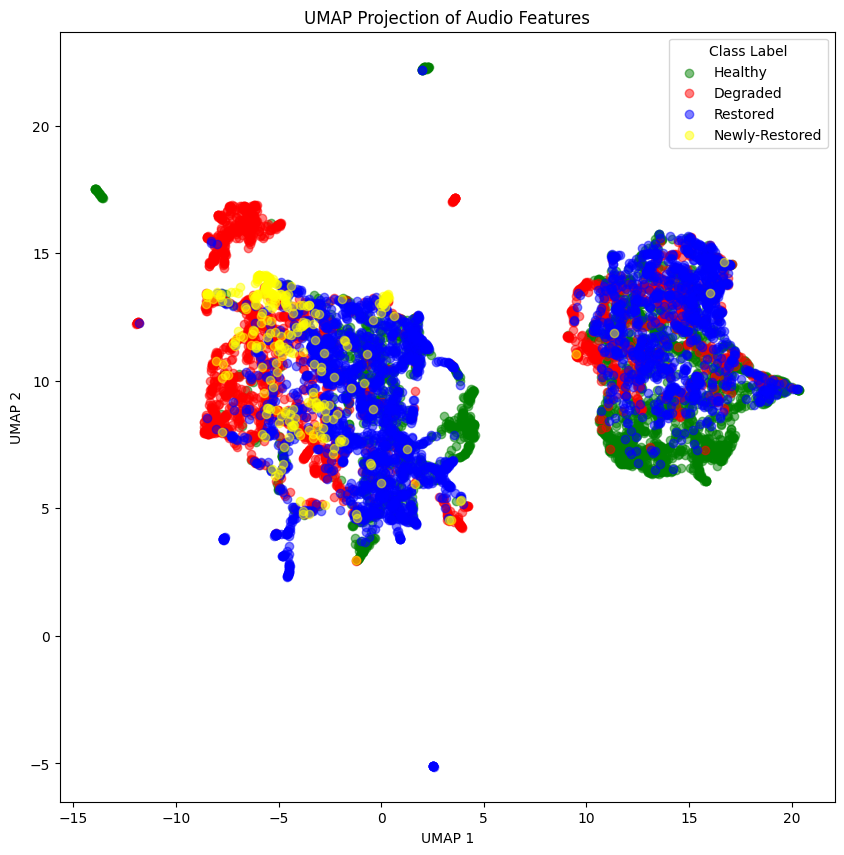

In [ ]:
# Mapping from single letters to words for descriptive labels
class_mapping = {'H': 'Healthy', 'D': 'Degraded', 'R': 'Restored', 'N': 'Newly-Restored'}
color_mapping = {'Healthy': 'green', 'Degraded': 'red', 'Restored': 'blue', 'Newly-Restored' : 'yellow'}

# Set up the plot
plt.figure(figsize=(10, 10))

# Plot each class with its own color and label using the mapping
for class_type, label in class_mapping.items():
    # Select only data rows with the current class_type, mapping them to descriptive labels on-the-fly
    indices = features_metadata_df['class_type'] == class_type
    plt.scatter(umap_embeddings[indices, 0], umap_embeddings[indices, 1], label=label,
                color=color_mapping[label], alpha=0.5)  # Assigning specific colors

plt.title('UMAP Projection of Audio Features')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Class Label')  # Adds a legend with a title
plt.show()

In [ ]:
from sklearn.mixture import GaussianMixture

# Fit GMM to the UMAP embeddings
number_of_clusters = 10
gmm = GaussianMixture(n_components=number_of_clusters, covariance_type='full', random_state=42)
gmm.fit(umap_embeddings)

# Predict cluster labels using GMM
gmm_labels = gmm.predict(umap_embeddings)


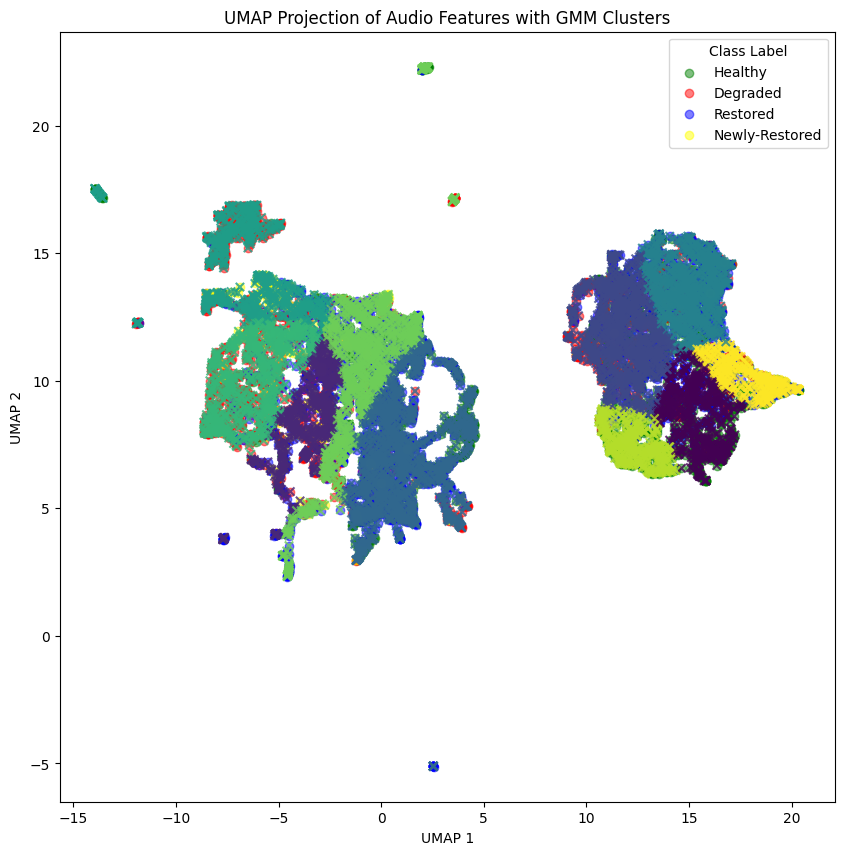

In [ ]:
# Set up the plot for UMAP with GMM clusters
plt.figure(figsize=(10, 10))

# Plot each class with its own color and label using the mapping
for class_type, label in class_mapping.items():
    indices = features_metadata_df['class_type'] == class_type
    plt.scatter(umap_embeddings[indices, 0], umap_embeddings[indices, 1], label=label,
                color=color_mapping[label], alpha=0.5)

# Overlay GMM clusters on the same plot
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=gmm_labels, cmap='viridis', marker='x', alpha=0.8)

plt.title('UMAP Projection of Audio Features with GMM Clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Class Label')  # Adds a legend with a title
plt.show()


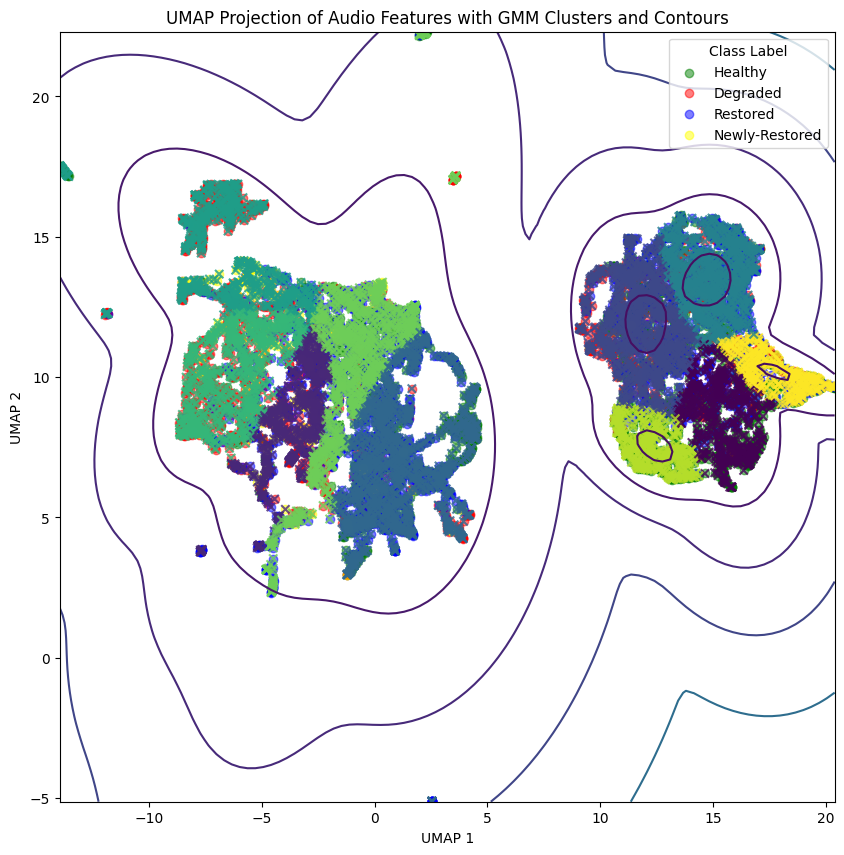

In [ ]:
import numpy as np

# Create a grid of points covering the UMAP space
x = np.linspace(umap_embeddings[:, 0].min(), umap_embeddings[:, 0].max(), 100)
y = np.linspace(umap_embeddings[:, 1].min(), umap_embeddings[:, 1].max(), 100)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T

# Evaluate GMM on the grid
Z = -gmm.score_samples(XX)
Z = Z.reshape(X.shape)

# Plot contour
plt.figure(figsize=(10, 10))
plt.contour(X, Y, Z, levels=np.logspace(0, 2, 10), cmap='viridis')

# Overlay original UMAP and GMM clusters
for class_type, label in class_mapping.items():
    indices = features_metadata_df['class_type'] == class_type
    plt.scatter(umap_embeddings[indices, 0], umap_embeddings[indices, 1], label=label,
                color=color_mapping[label], alpha=0.5)

plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=gmm_labels, cmap='viridis', marker='x', alpha=0.8)

plt.title('UMAP Projection of Audio Features with GMM Clusters and Contours')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Class Label')
plt.show()


In [ ]:
features_metadata_df

,filename,class_type,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_1271,feature_1272,feature_1273,feature_1274,feature_1275,feature_1276,feature_1277,feature_1278,feature_1279,cluster
0,clip_ind_H1_20220923_111200_4.wav,H,0.131103,0.030136,-0.047387,0.017165,-0.117165,0.094826,0.267618,-0.050158,...,0.061611,0.265818,-0.035269,-0.015084,0.030923,0.036561,-0.032412,0.190598,0.039754,2
1,clip_ind_R3_20220918_134200_8.wav,R,0.067938,0.106632,-0.018314,0.163699,-0.164718,0.075393,0.167201,-0.046661,...,0.000098,-0.026109,-0.073419,-0.003800,-0.002366,-0.079019,0.000032,0.158726,0.035083,1
2,clip_ind_H6_20220912_205600_8.wav,H,0.110186,-0.022474,0.054141,-0.034557,-0.133476,0.031377,0.188590,-0.056155,...,-0.018729,0.131846,0.036543,-0.013450,0.029775,-0.156735,-0.006686,0.060065,0.040798,4
3,clip_ind_D5_20220907_021800_0.wav,D,0.051740,-0.016742,-0.092446,0.055631,-0.133316,0.097867,0.075703,-0.062854,...,0.026109,0.216945,-0.029644,-0.012234,0.019303,-0.006413,-0.030960,0.103060,0.027151,2
4,clip_ind_R6_20220917_071800_3.wav,R,0.123010,-0.015957,-0.063505,-0.042481,-0.152605,0.093561,0.168606,-0.078542,...,-0.032073,0.232006,-0.033204,-0.008884,0.004558,-0.072910,-0.031181,0.114828,0.025838,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8307,clip_ind_R1_20220913_011400_0.wav,R,0.117916,0.008753,-0.036351,-0.014744,-0.161275,0.023347,0.185231,-0.071256,...,-0.010456,0.123761,0.047237,-0.019520,0.021795,-0.097389,-0.033784,0.149069,0.014143,3
8308,clip_ind_R6_20220917_041400_1.wav,R,0.021205,0.036336,0.010081,0.048430,-0.147853,0.016276,0.110845,-0.128221,...,-0.074872,0.059425,0.171190,0.004094,0.062087,-0.125937,-0.004916,0.074905,0.017555,3
8309,clip_ind_R4_20220919_100800_11.wav,R,0.118460,0.035709,0.005005,0.071951,-0.110683,0.045916,0.200827,-0.016383,...,-0.006117,0.044358,-0.074559,-0.005689,0.051839,0.128876,-0.024811,0.032129,0.049144,2
8310,clip_ind_D1_20220919_041400_0.wav,D,0.047160,0.040876,-0.066384,0.024975,-0.143683,0.080322,0.173268,-0.072831,...,-0.034039,0.049713,-0.063517,-0.001781,0.009489,-0.056850,-0.028146,0.107977,0.057594,4


In [ ]:
# Add the cluster labels to the DataFrame
features_metadata_df['cluster'] = gmm_labels

# Save the updated DataFrame to a CSV file
features_metadata_df.to_csv(features_metadata_path, index=False)

# Optional: Display the first few rows to verify the addition
display(features_metadata_df.head())

,filename,class_type,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_1271,feature_1272,feature_1273,feature_1274,feature_1275,feature_1276,feature_1277,feature_1278,feature_1279,cluster
0,clip_ind_H1_20220923_111200_4.wav,H,0.131103,0.030136,-0.047387,0.017165,-0.117165,0.094826,0.267618,-0.050158,...,0.061611,0.265818,-0.035269,-0.015084,0.030923,0.036561,-0.032412,0.190598,0.039754,3
1,clip_ind_R3_20220918_134200_8.wav,R,0.067938,0.106632,-0.018314,0.163699,-0.164718,0.075393,0.167201,-0.046661,...,0.000098,-0.026109,-0.073419,-0.003800,-0.002366,-0.079019,0.000032,0.158726,0.035083,5
2,clip_ind_H6_20220912_205600_8.wav,H,0.110186,-0.022474,0.054141,-0.034557,-0.133476,0.031377,0.188590,-0.056155,...,-0.018729,0.131846,0.036543,-0.013450,0.029775,-0.156735,-0.006686,0.060065,0.040798,2
3,clip_ind_D5_20220907_021800_0.wav,D,0.051740,-0.016742,-0.092446,0.055631,-0.133316,0.097867,0.075703,-0.062854,...,0.026109,0.216945,-0.029644,-0.012234,0.019303,-0.006413,-0.030960,0.103060,0.027151,1
4,clip_ind_R6_20220917_071800_3.wav,R,0.123010,-0.015957,-0.063505,-0.042481,-0.152605,0.093561,0.168606,-0.078542,...,-0.032073,0.232006,-0.033204,-0.008884,0.004558,-0.072910,-0.031181,0.114828,0.025838,7


In [ ]:
"""
# Grouping clips by clusters
clusters = features_metadata_df.groupby('cluster')['filename'].apply(list)

# Displaying clips in each cluster along with the count
for cluster_label, clips in clusters.items():
    print(f"Cluster {cluster_label}: ({len(clips)} files)")
    for clip in clips:
        print(clip)
    print("\n")
"""

'\n# Grouping clips by clusters\nclusters = features_metadata_df.groupby(\'cluster\')[\'filename\'].apply(list)\n\n# Displaying clips in each cluster along with the count\nfor cluster_label, clips in clusters.items():\n    print(f"Cluster {cluster_label}: ({len(clips)} files)")\n    for clip in clips:\n        print(clip)\n    print("\n")\n'

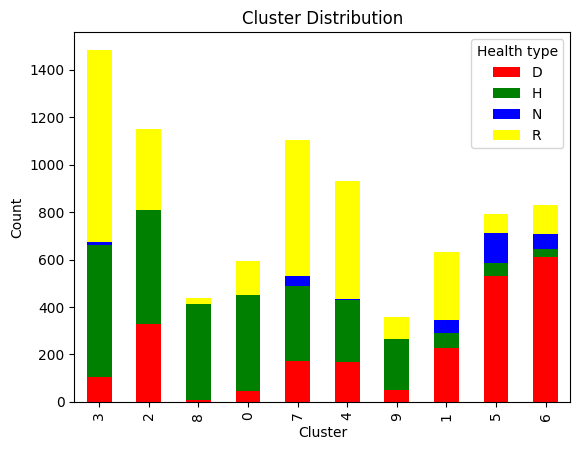

In [ ]:
# Group by 'cluster' and 'class_type', and count occurrences
cluster_class_counts = features_metadata_df.groupby(['cluster', 'class_type']).size().unstack().fillna(0)

# Sort clusters by the count of 'H' in descending order
if 'H' in cluster_class_counts.columns:
    cluster_class_counts = cluster_class_counts.sort_values(by='H', ascending=False)

# Create the bar plot
cluster_class_counts.plot(kind='bar', stacked=True, color=['red', 'green', 'blue', 'yellow'])
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Cluster Distribution')
plt.legend(title='Health type')
plt.show()


In [35]:

import os
import shutil

def organize_clips_by_cluster(df, source_base_folder, destination_base_folder):
    """
    Organizes audio clips into folders based on their cluster by copying the files.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the data with columns ['filename', 'cluster'].

    The function creates a folder for each cluster in the specified base folder and copies the corresponding files into those folders.
    """
    
    # Create the destination base folder if it doesn't exist
    if not os.path.exists(destination_base_folder):
        os.makedirs(destination_base_folder)
    
    # Iterate through each row in the DataFrame
    for index, row in df.iterrows():
        cluster_folder = os.path.join(destination_base_folder, f"cluster_{row['cluster']}")
        
        # Create the cluster folder if it doesn't exist
        if not os.path.exists(cluster_folder):
            os.makedirs(cluster_folder)
        
        # Source and destination file paths
        source_file = os.path.join(source_base_folder, row['filename'])
        destination_file = os.path.join(cluster_folder, os.path.basename(row['filename']))
        
        # Copy the file to the appropriate cluster folder
        shutil.copy2(source_file, destination_file)
        print(f"Copied {source_file} to {destination_file}")




In [36]:
"""
source_base_folder = "/home/os/aqoustics/Aqoustics-Surfperch/data/ROIs/"
destination_base_folder = "/home/os/aqoustics/Aqoustics-Surfperch/data/clusters/"
organize_clips_by_cluster(features_metadata_df, source_base_folder, destination_base_folder)
"""

'\nsource_base_folder = "/home/os/aqoustics/Aqoustics-Surfperch/data/ROIs/"\ndestination_base_folder = "/home/os/aqoustics/Aqoustics-Surfperch/data/clusters/"\norganize_clips_by_cluster(features_metadata_df, source_base_folder, destination_base_folder)\n'